# T-Pot Results

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import json
import pycountry
import matplotlib.dates as mdates
import time
plt.style.use('ggplot')

## Attack distribution

In [2]:
df = pd.read_csv("./data/Honeypot Attacks Bar.csv")
df = df.sort_values(by=['Honeypots'])
df.head()

,Honeypots,Attacks
0,Adbhoney,9302
1,Ciscoasa,674
2,CitrixHoneypot,1121
3,ConPot,615
4,Cowrie,75511


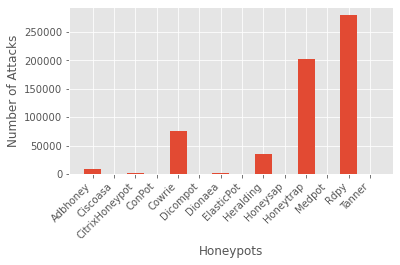

In [3]:
x = df['Honeypots'].to_numpy()
y = df['Attacks'].to_numpy()

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y)

plt.ylabel("Number of Attacks")
plt.xlabel("Honeypots")

plt.gcf().subplots_adjust(bottom=0.30, left=0.15)
plt.xticks(x_pos, x)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.savefig("tpot-overview-attacks.pdf", format="pdf", transparent=True)

plt.show()

## Attack Map

In [4]:
from shapely.geometry import Point

In [18]:
df = pd.read_csv("./data/Honeypot Attack Map.csv")
geos = df["Geo Centroid"].to_numpy()
lats = []
lons = []
for geo in geos:
    test = json.loads(geo)
    lats.append(test["lat"])
    lons.append(test["lon"])
df["Longitude"] = lons
df["Latitude"] = lats
df.head()

,Filter,Geohash,Count,Geo Centroid,Longitude,Latitude
0,NaN,u0,"109,705","{\n ""lat"": 49.60602676299543,\n ""lon"": 7.514...",7.514657,49.606027
1,NaN,u1,"74,478","{\n ""lat"": 51.90162099285427,\n ""lon"": 6.913...",6.913701,51.901621
2,NaN,9y,"73,996","{\n ""lat"": 37.751111446329,\n ""lon"": -97.820...",-97.820710,37.751111
3,NaN,uc,"53,038","{\n ""lat"": 55.727742240422,\n ""lon"": 37.6077...",37.607720,55.727742
4,NaN,wt,"28,149","{\n ""lat"": 31.731900685061067,\n ""lon"": 119....",119.160638,31.731901


In [19]:
geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
crs = {'epsg:4326'}
geo_df = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

In [20]:
df = pd.read_csv("./data/Attacks by Country.csv")
df.Count = df.Count.str.replace(',', '').astype(int)

exception = {
    "Russia": "Russian Federation",
    "South Korea": "Korea, Republic of",
    "Palestine": "Palestine, State of",
    "Iran": "Iran, Islamic Republic of",
    "Syria": "Syrian Arab Republic",
    "Brunei": "Brunei Darussalam",
    "DR Congo": "Congo, The Democratic Republic of the",
    "Ivory Coast": "Côte d'Ivoire",
    "Sint Maarten": "Sint Maarten (Dutch part)"
    
    
}

country_name = {}
for country in pycountry.countries:
    country_name[country.name] = country.alpha_3
    if hasattr(country, 'common_name'):
        country_name[country.common_name] = country.alpha_3
    if hasattr(country, 'official_name'):
        country_name[country.official_name] = country.alpha_3
    if hasattr(country, 'numeric'):
        country_name[country.numeric] = country.alpha_3
codes = []
for country in df["geoip.country_name.keyword: Descending"]:
    
    code = country_name.get(country, 'Unknown code')
    if code == 'Unknown code':
        if country in exception:
            codes.append(country_name.get(exception.get(country), 'Unknown code'))
        else:
            print(country)
            codes.append(code)
    else:
        codes.append(code)
df["iso_a3"] = codes
df.head()

,geoip.country_name.keyword: Descending,Count,iso_a3
0,United States,141916,USA
1,Germany,97338,DEU
2,Russia,73376,RUS
3,Netherlands,41775,NLD
4,China,38254,CHN


In [21]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world = pd.merge(world, df, on='iso_a3')
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,geoip.country_name.keyword: Descending,Count
0,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,2652
1,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States,141916
2,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",Kazakhstan,34
3,260580739,Asia,Indonesia,IDN,3028000.0,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ...",Indonesia,3308
4,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...",Argentina,135


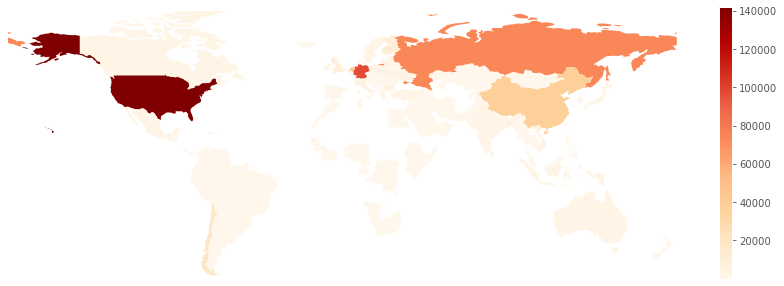

In [22]:
fig, ax = plt.subplots(figsize = (15, 5))
world.plot(ax=ax, column="Count", cmap='OrRd', legend=True)
ax.set_facecolor('white')
# geo_df.plot(ax=ax)

plt.xticks([])
plt.yticks([])
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

fig.savefig("tpot-overview-map.pdf", format="pdf", bbox_inches="tight", pad_inches=0, transparent=True)

## Attack histogram

In [23]:
df = pd.read_csv("./data/Attacks by Honeypot Histogram.csv")
df.Attacks = df.Attacks.str.replace(',', '').astype(int)
df.Timestamp = pd.to_datetime(df.Timestamp)
df.head()

,type.keyword: Descending,Timestamp,Attacks
0,Rdpy,2021-09-27 12:00:00,24
1,Rdpy,2021-09-28 00:00:00,261
2,Rdpy,2021-09-28 12:00:00,34474
3,Rdpy,2021-09-29 00:00:00,3153
4,Rdpy,2021-09-29 12:00:00,7640


In [24]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

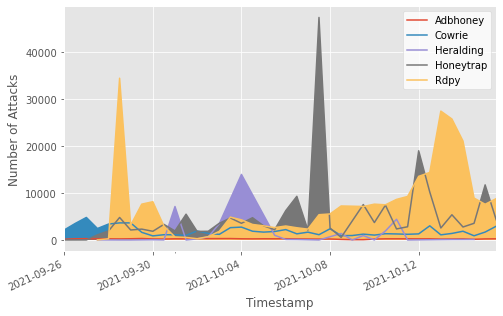

In [25]:
fig, ax = plt.subplots(figsize = (8,5))

for k, d in df.groupby('type.keyword: Descending'):
    x = d['Timestamp'].to_numpy()
    y = d['Attacks'].to_numpy()
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    
    #ax.scatter(x,y)
    ax.plot(x,y, label=k)
    ax.fill_between(x, y)


fig.autofmt_xdate()
ax.set_ylabel("Number of Attacks")
ax.set_xlabel("Timestamp")

# Major ticks every 6 months.
fmt_half_year = mdates.DayLocator(interval=4)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Round to nearest years.
datemin = df.Timestamp.min()
datemax = df.Timestamp.max()
ax.set_xlim(datemin, datemax)

# Put a legend to the right of the current axis
legend = plt.legend(loc='upper right',frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.xticks( rotation=25 )
plt.gcf().subplots_adjust(left=0.15)
plt.savefig("tpot-attacks-histogram.pdf", format="pdf", bbox_inches="tight", pad_inches=0, transparent=True)
plt.show()

## Suricata

In [55]:
df = pd.read_csv("./data/Suricata Alert Category Histogram.csv")

df.Attacks = df.Attacks.str.replace(',', '').astype(int)

df.Timestamp = pd.to_datetime(df.Timestamp)

dfs = [x for _, x in df.groupby('alert.category.keyword: Descending')]
df = df.loc[~df.index.duplicated(), :]
r = pd.date_range(start=df.Timestamp.min(), end=df.Timestamp.max(), freq='12h')

dfs_new = []
for dfi in dfs:
    name = dfi["alert.category.keyword: Descending"].unique()[0]
    dfi = dfi.set_index('Timestamp').reindex(r).fillna({'alert.category.keyword: Descending':name, 'Attacks':0}).rename_axis('Timestamp').reset_index()
    dfs_new.append(dfi)

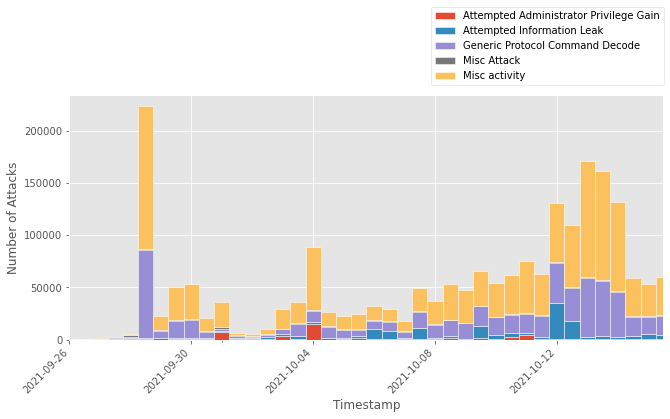

In [56]:
fig, ax = plt.subplots(figsize = (15,5))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))

dataset_1 = dfs_new[0]
x_1 = dataset_1["Timestamp"]
y_1 = dataset_1["Attacks"]
k_1 = dataset_1["alert.category.keyword: Descending"].unique()[0]

ax.bar(x_1, y_1, 0.5, edgecolor='white', label=k_1)

dataset_2 = dfs_new[1]
x_2 = dataset_2["Timestamp"]
y_2 = dataset_2["Attacks"]
k_2 = dataset_2["alert.category.keyword: Descending"].unique()[0]
ax.bar(x_2, y_2, 0.5, bottom=y_1.to_numpy(), edgecolor='white',label=k_2)

dataset_3 = dfs_new[2]
x_3 = dataset_3["Timestamp"]
y_3 = dataset_3["Attacks"]
k_3 = dataset_3["alert.category.keyword: Descending"].unique()[0]
ax.bar(x_3, y_3, 0.5, bottom=y_1.to_numpy()+y_2.to_numpy(), edgecolor='white',label=k_3)
    
    
dataset_4 = dfs_new[3]
x_4 = dataset_4["Timestamp"]
y_4 = dataset_4["Attacks"]
k_4 = dataset_4["alert.category.keyword: Descending"].unique()[0]
ax.bar(x_4, y_4, 0.5, bottom=y_1.to_numpy()+y_2.to_numpy()+y_3.to_numpy(), edgecolor='white',label=k_4)

dataset_5 = dfs_new[4]
x_5 = dataset_5["Timestamp"]
y_5 = dataset_5["Attacks"]
k_5 = dataset_5["alert.category.keyword: Descending"].unique()[0]
ax.bar(x_5, y_5, 0.5, bottom=y_1.to_numpy()+y_2.to_numpy()+y_3.to_numpy()+y_4.to_numpy(), edgecolor='white',label=k_5)

fig.autofmt_xdate()
plt.ylabel("Number of Attacks")
plt.xlabel("Timestamp")

# Major ticks every 6 months.
fmt_half_year = mdates.DayLocator(interval=4)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Round to nearest years.
datemin = df.Timestamp.min()
datemax = df.Timestamp.max()
ax.set_xlim(datemin, datemax)

# Put a legend to the right of the current axis
legend = plt.legend(loc='center left', bbox_to_anchor=(0.6, 1.2), frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.xticks( rotation=25 )
plt.gcf().subplots_adjust(left=0.35)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.savefig("tpot-suricata-alerts.pdf", format="pdf", bbox_inches="tight", pad_inches=0, transparent=True)
plt.show()

## Honeytrap

In [28]:
df = pd.read_csv("./data/Honeytrap - Attacks by Destination Ports Histogram.csv")
df.Attacks = df.Attacks.str.replace(',', '').astype(int)
df.Timestamp = pd.to_datetime(df.Timestamp)
df.head()

,dest_port: Descending,Timestamp,Attacks
0,5038,2021-09-27 12:00:00,21
1,5038,2021-09-28 12:00:00,2419
2,5038,2021-09-29 12:00:00,71
3,5038,2021-10-01 12:00:00,120
4,5038,2021-10-03 00:00:00,1567


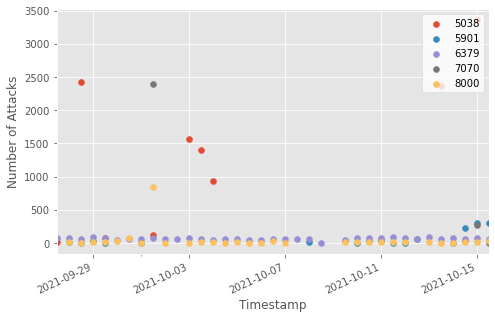

In [29]:
fig, ax = plt.subplots(figsize = (8,5))

for k, d in df.groupby('dest_port: Descending'):
    x = d['Timestamp'].to_numpy()
    y = d['Attacks'].to_numpy()
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    
    ax.scatter(x,y, label=k)
    
    #ax.plot(x,y, label=k)
    #ax.fill_between(x, y)


fig.autofmt_xdate()
ax.set_ylabel("Number of Attacks")
ax.set_xlabel("Timestamp")

# Major ticks every 6 months.
fmt_half_year = mdates.DayLocator(interval=4)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Round to nearest years.
datemin = df.Timestamp.min()
datemax = df.Timestamp.max()
ax.set_xlim(datemin, datemax)

# Put a legend to the right of the current axis
legend = plt.legend(loc='upper right',frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.xticks( rotation=25 )
plt.gcf().subplots_adjust(left=0.15)
plt.savefig("tpot-honeytrap-port.pdf", format="pdf", bbox_inches="tight", pad_inches=0, transparent=True)
plt.show()

## Cowire

In [30]:
df = pd.read_csv("./data/Cowrie - Attacks by Destination Ports Histogram.csv")
df.Timestamp = pd.to_datetime(df.Timestamp)
df.head()

,dest_port: Descending,Timestamp,Attacks
0,22,2021-09-26 00:00:00,357
1,22,2021-09-26 12:00:00,657
2,22,2021-09-27 00:00:00,837
3,22,2021-09-27 12:00:00,441
4,22,2021-09-28 00:00:00,667


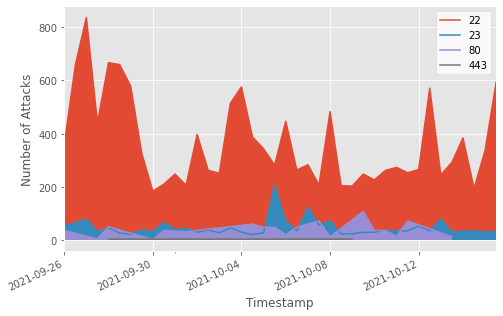

In [31]:
fig, ax = plt.subplots(figsize = (8,5))

for k, d in df.groupby('dest_port: Descending'):
    x = d['Timestamp'].to_numpy()
    y = d['Attacks'].to_numpy()
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    
    #ax.scatter(x,y)
    ax.plot(x,y, label=k)
    ax.fill_between(x, y)


fig.autofmt_xdate()
ax.set_ylabel("Number of Attacks")
ax.set_xlabel("Timestamp")

# Major ticks every 6 months.
fmt_half_year = mdates.DayLocator(interval=4)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Round to nearest years.
datemin = df.Timestamp.min()
datemax = df.Timestamp.max()
ax.set_xlim(datemin, datemax)

# Put a legend to the right of the current axis
legend = plt.legend(loc='upper right',frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.xticks( rotation=25 )
plt.gcf().subplots_adjust(left=0.15)
plt.savefig("tpot-cowrie-port.pdf", format="pdf", bbox_inches="tight", pad_inches=0, transparent=True)
plt.show()

In [32]:
df = pd.read_csv("./data/Cowrie Password Tagcloud.csv")
df.head()

,password.keyword: Descending,Count
0,1,851
1,123456,597
2,1234,272
3,!ishtar,229
4,x,227


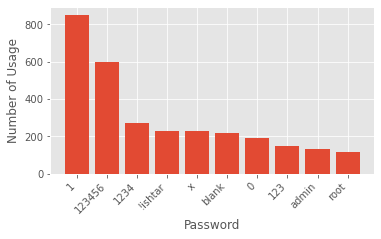

In [33]:
x = df.head(10)['password.keyword: Descending'].to_numpy()
y = df.head(10)['Count'].to_numpy()

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y)

plt.ylabel("Number of Usage")
plt.xlabel("Password")

plt.gcf().subplots_adjust(bottom=0.30, left=0.15)
plt.xticks(x_pos, x)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.savefig("tpot-cowrie-password.pdf", format="pdf", transparent=True)

plt.show()

In [34]:
df = pd.read_csv("./data/Cowrie Username Tagcloud.csv")
# df.Count = df.Count.str.replace(',', '').astype(int)
df.head()

,username.keyword: Descending,Count
0,root,7299
1,user,2037
2,admin,318
3,!root,229
4,blank,217


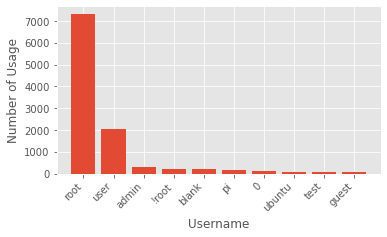

In [35]:
x = df.head(10)['username.keyword: Descending'].to_numpy()
y = df.head(10)['Count'].to_numpy()

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y)

plt.ylabel("Number of Usage")
plt.xlabel("Username")

plt.gcf().subplots_adjust(bottom=0.30, left=0.15)
plt.xticks(x_pos, x)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.savefig("tpot-cowrie-username.pdf", format="pdf", transparent=True)

plt.show()

In [36]:
df = pd.read_csv("./data/cowrie-cmd.txt")
df.Timestamp = pd.to_datetime(df.Timestamp)
df = df.sort_values(by="Timestamp")
df.head()

,Timestamp,Number,Version
0,2015-06-08,23,1.0.0-alpha
1,2016-06-11,30,1.1.0
2,2017-06-28,34,1.2.0
3,2018-04-15,35,1.3.0
4,2018-07-23,37,1.4.0


['2015-06-08T00:00:00.000000000' '2016-06-11T00:00:00.000000000'
 '2017-06-28T00:00:00.000000000' '2018-04-15T00:00:00.000000000'
 '2018-07-23T00:00:00.000000000' '2019-05-11T00:00:00.000000000'
 '2019-10-30T00:00:00.000000000' '2019-10-31T00:00:00.000000000'
 '2019-12-09T00:00:00.000000000' '2020-04-30T00:00:00.000000000'
 '2020-10-11T00:00:00.000000000' '2021-10-17T00:00:00.000000000'] [23 30 34 35 37 41 41 41 41 43 46 46]


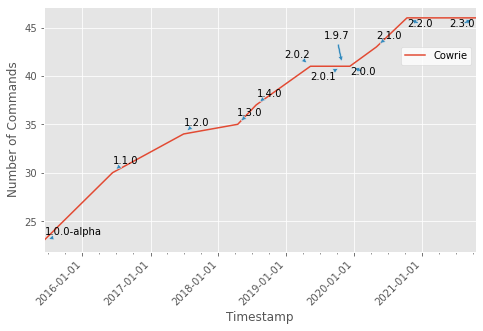

In [37]:
from adjustText import adjust_text
from matplotlib import dates

fig, ax = plt.subplots(figsize = (8,5))

#for k, d in df.groupby('Version'):
x = df['Timestamp'].to_numpy()
y = df['Number'].to_numpy()
z = df['Version'].to_numpy()
    
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
    
texts = []
ax.plot(x,y, label="Cowrie")
for i,j,k in zip(x,y,z):
    texts.append(ax.annotate(k, xy=(i, j), xytext=(i,j+.4), arrowprops={'arrowstyle' : 'simple', 'shrinkB' : 5}))
    #ax.plot(x,y, label=k)
    #ax.fill_between(x, y)
print(x,y)

fig.autofmt_xdate()
ax.set_ylabel("Number of Commands")
ax.set_xlabel("Timestamp")

# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=12)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator(interval=3)
ax.xaxis.set_minor_locator(fmt_month)

# Round to nearest years.
datemin = df.Timestamp.min()
datemax = df.Timestamp.max()
ax.set_xlim(datemin, datemax)

# Put a legend to the right of the current axis
legend = plt.legend(loc='center left', bbox_to_anchor=(0.815, 0.80), frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

#adjust_text(texts)
x1 = dates.date2num(x)
adjust_text(texts, x1,y,only_move={'points':'y', 'texts':'y'}, force_points=0.15)
#adjust_text(texts, x=x, y=y, autoalign='y',
#            only_move={'points':'y', 'text':'y'}, force_points=0.15)

plt.xticks( rotation=25 )
plt.gcf().subplots_adjust(left=0.15)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.savefig("cowrie-cmd.pdf", format="pdf", bbox_inches="tight", pad_inches=0, transparent=True)
plt.show()

## RDPY

In [38]:
df = pd.read_csv("./data/Rdpy Attacks Histogram.csv")
df.Attacks = df.Attacks.str.replace(',', '').astype(int)
df.Timestamp = pd.to_datetime(df.Timestamp)
df.head()

,Timestamp,Attacks,Unique Src IPs
0,2021-09-27 12:00:00,24,10
1,2021-09-28 00:00:00,261,47
2,2021-09-28 12:00:00,34474,39
3,2021-09-29 00:00:00,3153,29
4,2021-09-29 12:00:00,7640,28


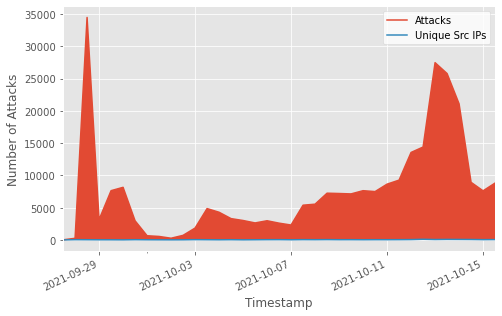

In [39]:
fig, ax = plt.subplots(figsize = (8,5))


x = df['Timestamp'].to_numpy()
y = df['Attacks'].to_numpy()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator())

#ax.scatter(x,y)
ax.plot(x,y, label="Attacks")
ax.fill_between(x, y)

x = df['Timestamp'].to_numpy()
y = df['Unique Src IPs'].to_numpy()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator())

#ax.scatter(x,y)
ax.plot(x,y, label="Unique Src IPs")
ax.fill_between(x, y)

fig.autofmt_xdate()
ax.set_ylabel("Number of Attacks")
ax.set_xlabel("Timestamp")

# Major ticks every 6 months.
fmt_half_year = mdates.DayLocator(interval=4)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Round to nearest years.
datemin = df.Timestamp.min()
datemax = df.Timestamp.max()
ax.set_xlim(datemin, datemax)

# Put a legend to the right of the current axis
legend = plt.legend(loc='upper right',frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.xticks( rotation=25 )
plt.gcf().subplots_adjust(left=0.15)
plt.savefig("tpot-rdpy-port.pdf", format="pdf", bbox_inches="tight", pad_inches=0, transparent=True)
plt.show()

# Fingerprinting Honeypots

## Cosine Simularity

In [40]:
import math
import re
from collections import Counter

WORD = re.compile(r"\w+")


def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)


text1 = """
root@127.0.0.1's password:\n
"""

text2 = """
Bad packet length 1349676916.\n
ssh_dispatch_run_fatal: Connection to 127.0.0.1 port 65522: message authentication code incorrect\n
"""

vector1 = text_to_vector(text1)
vector2 = text_to_vector(text2)

cosine = get_cosine(vector1, vector2)

print("Cosine:", cosine)

Cosine: 0.45883146774112343


In [5]:
import math
import numpy as np

std_embeddings_index = {}
with open('data/numberbatch-en.txt') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        std_embeddings_index[word] = embedding

def cosineValue(v1,v2):
    "compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)"
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy/math.sqrt(sumxx*sumyy)


def get_sentence_vector(sentence, std_embeddings_index = std_embeddings_index ):
    sent_vector = 0
    for word in sentence.lower().split():
        if word not in std_embeddings_index :
            word_vector = np.array(np.random.uniform(-1.0, 1.0, 300))
            std_embeddings_index[word] = word_vector
        else:
            word_vector = std_embeddings_index[word]
        sent_vector = sent_vector + word_vector

    return sent_vector

def cosine_sim(sent1, sent2):
    return cosineValue(get_sentence_vector(sent1), get_sentence_vector(sent2))

In [9]:
text1 = """
The authenticity of host '127.0.0.1 (127.0.0.1)' can't be established.\n
ED25519 key fingerprint is SHA256:y9LeDbIlEePuWlnog3rZh0QuMnlKZ1bvky6z/nM2Okk.\n
This key is not known by any other names\n
Are you sure you want to continue connecting (yes/no/[fingerprint])?\n
"""

text2 = """
Bad packet length 1349676916.\n
ssh_dispatch_run_fatal: Connection to 127.0.0.1 port 65522: message authentication code incorrect\n
"""

print(cosine_sim(text1, text2))

0.01777983693768669


## Cosine with Sklearn

In [4]:
# Define the documents
text1 = """
root@127.0.0.1's password:\n
"""

text2 = """
Bad packet length 1349676916.\n
ssh_dispatch_run_fatal: Connection to 127.0.0.1 port 65522: message authentication code incorrect\n
"""

documents = [text1, text2]

In [6]:
# Scikit Learn
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Create the Document Term Matrix
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer = CountVectorizer()
sparse_matrix = count_vectorizer.fit_transform(documents)

# OPTIONAL: Convert Sparse Matrix to Pandas Dataframe if you want to see the word frequencies.
doc_term_matrix = sparse_matrix.todense()
df = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=['text1', 'text2'])
df

,127,1349676916,65522,authentication,bad,code,connection,incorrect,length,message,packet,password,port,root,ssh_dispatch_run_fatal,to
text1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
text2,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1


In [7]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(df, df))

[[1.         0.15430335]
 [0.15430335 1.        ]]


## Soft Cosine Similarity

In [27]:
# Define the documents
text1 = 'root@127.0.0.1\'s password:\n'.split()

text2 = 'Bad packet length 1349676916.\nssh_dispatch_run_fatal: Connection to 127.0.0.1 port 65522: message authentication code incorrect\n'.split()
#text2 = 'stefan@127.0.0.1\'s password:\n'.split()


documents = [text1, text2]

In [9]:
import gensim
# upgrade gensim if you can't import softcossim
#from gensim.matutils import softcossim 
import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim import corpora
print(gensim.__version__)
#> '3.6.0'
# Download the FastText model
fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')

4.1.2


In [28]:
from gensim.similarities import SparseTermSimilarityMatrix, WordEmbeddingSimilarityIndex
# Prepare a dictionary and a corpus.
dictionary = corpora.Dictionary(documents)

# Prepare the similarity matrix
similarity_index = WordEmbeddingSimilarityIndex(fasttext_model300)
similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary)

# Convert the sentences into bag-of-words vectors.
text1 = dictionary.doc2bow(text1)
text2 = dictionary.doc2bow(text2)

# Compute soft cosine similarity
print(similarity_matrix.inner_product(text1, text2,  normalized=(True, False)))

0.0
